In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# MLP Classifier Modeling

In [2]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
                                shape=(input_shape[-1], self.units),
                                initializer="he_normal",
                                trainable=True,
                                name = 'weight'
        )
        self.b = self.add_weight(
                                shape=(self.units,), 
                                initializer="random_normal", 
                                trainable=True,
                                name = 'bias'
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [3]:
class FC_Block(tf.keras.layers.Layer) : 
    def __init__(self, units = 32) : 
        super(FC_Block, self).__init__()
        self.units = units
        self.linear = Linear(self.units)
        self.batch = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, inputs, training = False) : 
        x = self.linear(inputs)
        x = self.batch(x, training = training) 
        x = self.relu(x)
        x = self.dropout(x)

        return x


In [4]:
class MLP_Classifier(tf.keras.Model) : 
    def __init__(self) : 
        super(MLP_Classifier, self).__init__()
        self.mlp1 = FC_Block(256)
        self.mlp2 = FC_Block(64)
        self.mlp3 = FC_Block(16)
        self.linear = Linear(10)
    
    def call(self, inputs) : 
        x = self.mlp1(inputs)
        x = self.mlp2(x)
        x = self.mlp3(x)
        x = self.linear(x)

        return tf.nn.softmax(x)

In [5]:
mlp = MLP_Classifier()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
mlp.compile(optimizer, loss = loss_fn, metrics = ['accuracy'])

# Setting Data

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, y_train, X_test, y_test = X_train.astype(float), y_train.astype(float), X_test.astype(float), y_test.astype(float)
X_train = X_train.reshape(-1,28 * 28) / 255
X_test = X_test.reshape(-1,28 * 28) / 255

print("TRAIN DATA : ", X_train.shape, y_train.shape)
print("TEST  DATA : ", X_test.shape, y_test.shape)

TRAIN DATA :  (60000, 784) (60000,)
TEST  DATA :  (10000, 784) (10000,)


In [7]:
from sklearn.model_selection import train_test_split
train_idx, valid_idx = train_test_split(np.arange(X_train.shape[0]), test_size = 0.2, shuffle = True, random_state = 100, stratify = y_train)
X_train_images = X_train[train_idx]
X_train_labels = y_train[train_idx]
X_valid_images = X_train[valid_idx]
X_valid_labels = y_train[valid_idx]

print("TRAIN DATA : ", X_train_images.shape, X_train_labels.shape)
print("VALID DATA : ", X_valid_images.shape, X_valid_labels.shape)

TRAIN DATA :  (48000, 784) (48000,)
VALID DATA :  (12000, 784) (12000,)


# Training

In [8]:
def return_callbacks(save_path, patience) : 
    early = tf.keras.callbacks.EarlyStopping('val_loss', patience = patience, mode = 'min')
    mckt = tf.keras.callbacks.ModelCheckpoint(save_path, monitor = 'val_loss', save_weights_only=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = patience // 3, min_lr = 1e-5)

    return [early, mckt, reduce_lr]

In [9]:
def draw_history(history) : 
    import matplotlib
    import matplotlib.pyplot as plt
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()

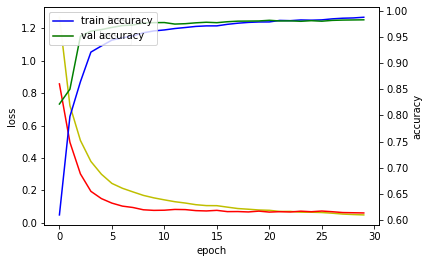

In [10]:
ckpt = 'checkpoint.h5'
patience = 20
history = mlp.fit(X_train_images, X_train_labels,
        validation_data = (X_valid_images, X_valid_labels),
        batch_size = 480,
        epochs = 30,
        verbose = 0, 
        callbacks= return_callbacks(ckpt, patience)
        )
draw_history(history)

# Prediction

In [11]:
mlp.load_weights('checkpoint.h5')
y_pred = mlp.predict(X_test)
pred = np.argmax(y_pred, axis = 1)
accuracy = sum(pred == y_test) / y_test.shape[0]
print('Accuracy : ', accuracy)

Accuracy :  0.9826


# Draw Plot

In [12]:
def draw_wrong_images(X_test, y_test, y_pred) : 
    import matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize = (6,12))
    wrong_idxes = [idx for idx,x in enumerate(y_test == pred) if x == False]
    wrong_images = X_test[wrong_idxes].reshape(-1,28,28)
    wrong_labels = y_pred[wrong_idxes]
    correct_labels = y_test[wrong_idxes]

    for i in  range(1,11) : 
        rs = np.random.randint(len(wrong_idxes))
        wrong_image = wrong_images[rs]
        wrong_label = wrong_labels[rs]
        correct_label = correct_labels[rs] 
        plt.subplot(5,2,i)
        plt.imshow(wrong_image)
        plt.title(f'{correct_label} => {wrong_label}')
        plt.axis('off')

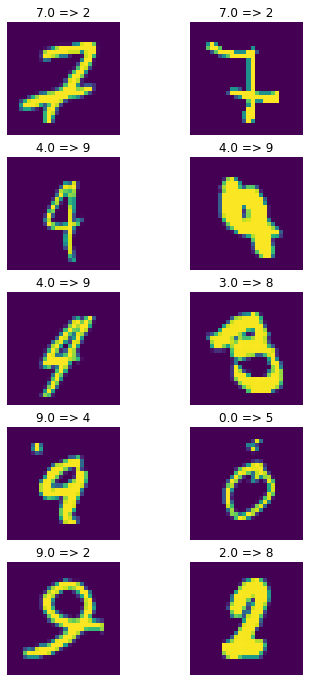

In [13]:
draw_wrong_images(X_test, y_test, pred)